In [121]:
import torch
import math
import numpy as np
import dlc_practical_prologue as prologue
from torch import optim
from torch import Tensor
from torch import nn
from torch.nn import functional as F
from helpers import *
from NaiveSiamese import NaiveSiamese
from EnhancedSiamese import EnhancedSiamese
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [48]:
N = 1000 # Number of data samples in training and test set

# load data from source
train_input, train_target, train_classes, \
    test_input, test_target, test_classes = prologue.generate_pair_sets(N)

# use 1-hot encoding for targets
train_target = encode_to_one_hot(train_target)
test_target = encode_to_one_hot(test_target)

In [61]:
mean = train_input.mean(dim=(0,2,3), keepdim=True)
std = train_input.std(dim=(0,2,3), keepdim=True)

# Normalize data by removing mean and subtracting by the std
normalize(train_input, mean, std)
normalize(test_input, mean, std)

# Preprocess the data 
train_input_1, train_input_2, train_classes_1, train_classes_2 = process_data(train_input, train_classes)
test_input_1, test_input_2, test_classes_1, test_classes_2 = process_data(test_input, test_classes)

In [118]:
verbose = False

nb_rounds = 10

# Containers for error rates ( 0 < error < 1 )
errors = np.zeros(10)
errors_naive = np.zeros(10)

# Few tweaking parameters

nb_epochs = 25 # Number of epochs
lr = 1e-1 # learning rate of the gradient descent algorithm
nb_hidden = 500 # Size of the hidden layer 


for i in range(0,nb_rounds):
    
    print('Round {}'.format(i))
    
    # Data shuffling 
    train_input_1,train_input_2,train_classes_1,train_classes_2,train_target = shuffle_data(train_input_1,train_input_2,train_classes_1,train_classes_2,train_target)
    
    # Naive siamese train and test
    naive_siamese = NaiveSiamese(nb_hidden=nb_hidden) # for weight reinitialization
    naive_siamese.train(train_input_1,train_input_2,train_target,nb_epochs=nb_epochs,lr=lr,verbose=verbose)
    error_naive = naive_siamese.compute_errors(test_input_1,test_input_2,test_target)
    
    # Enhanced siamese train and test 
    enhanced_siamese = EnhancedSiamese(nb_hidden=nb_hidden) # for weight reinitialization
    enhanced_siamese.train(train_input_1,train_input_2,train_classes_1,train_classes_2,train_target,nb_epochs=nb_epochs,lr=lr,verbose=verbose)
    error = enhanced_siamese.compute_errors(test_input_1,test_input_2,test_target)
    
    # Fill results
    errors[i] = error
    errors_naive[i] = error_naive

mean,std = errors.mean(),errors.std()
mean_naive,std_naive = errors_naive.mean(),errors_naive.std()
    

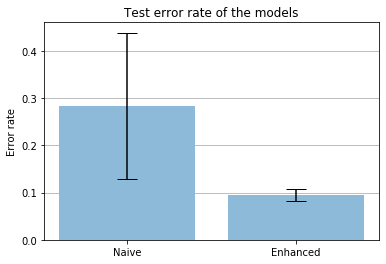

In [122]:
model_names = ['Naive','Enhanced']
x_pos = np.arange(len(model_names))
means = [mean_naive,mean]
stds = [std_naive,std]

# Build the plot
fig, ax = plt.subplots()
ax.bar(x_pos, means, yerr=stds, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Error rate')
ax.set_xticks(x_pos)
ax.set_xticklabels(model_names)
ax.set_title('Test error rate of the models')
ax.yaxis.grid(True)

# Save the figure and show
plt.show()
